In [1]:
import pandas as pd

# Load the metadata CSV file
metadata_path = 'HAM10000_metadata.csv'  # Adjust this path as necessary
metadata = pd.read_csv(metadata_path)

# Display the first few rows of the metadata
print(metadata.head())

     lesion_id      image_id dx_class dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419      bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030      bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769      bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661      bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633      bkl   histo  75.0  male          ear


In [3]:
import os
import shutil
import random
import pandas as pd

def organize_dataset(metadata_path, image_folders, target_base_dir, train_ratio=0.8, val_ratio=0.10):
    metadata = pd.read_csv(metadata_path)
    categories = metadata['dx_class'].unique()
    
    for category in categories:
        os.makedirs(os.path.join(target_base_dir, 'train', category), exist_ok=True)
        os.makedirs(os.path.join(target_base_dir, 'val', category), exist_ok=True)
        os.makedirs(os.path.join(target_base_dir, 'test', category), exist_ok=True)
    
    for index, row in metadata.iterrows():
        img_file = row['image_id'] + '.jpg'
        label = row['dx_class']
        
        # Search for the image file in the provided image folders
        src_file = None
        for folder in image_folders:
            potential_path = os.path.join(folder, img_file)
            if os.path.exists(potential_path):
                src_file = potential_path
                break
        
        if not src_file:
            continue
        
        split = random.random()
        if split < train_ratio:
            dst_dir = 'train'
        elif split < train_ratio + val_ratio:
            dst_dir = 'val'
        else:
            dst_dir = 'test'
        
        dst_file = os.path.join(target_base_dir, dst_dir, label, img_file)
        shutil.copy(src_file, dst_file)

# Define source directories and target base directory
metadata_path = 'HAM10000_metadata.csv'  # Change this path accordingly
image_folders = ['HAM10000_images_part_1', 'HAM10000_images_part_2']  # Change these paths accordingly
target_base_dir = 'dataset'

# Organize the dataset
organize_dataset(metadata_path, image_folders, target_base_dir)


In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the paths to your datasets
train_dir = os.path.join(target_base_dir, 'train')
val_dir = os.path.join(target_base_dir, 'val')
test_dir = os.path.join(target_base_dir, 'test')

# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Load and iterate datasets
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Get the class indices
class_indices = train_generator.class_indices
print("Classes found in the dataset:", class_indices)


# Print the class names
class_names = list(class_indices.keys())
print("Class names found in the dataset:", class_names)



C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 10015 images belonging to 7 classes.
Found 9371 images belonging to 7 classes.
Found 9404 images belonging to 7 classes.
Classes found in the dataset: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Class names found in the dataset: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


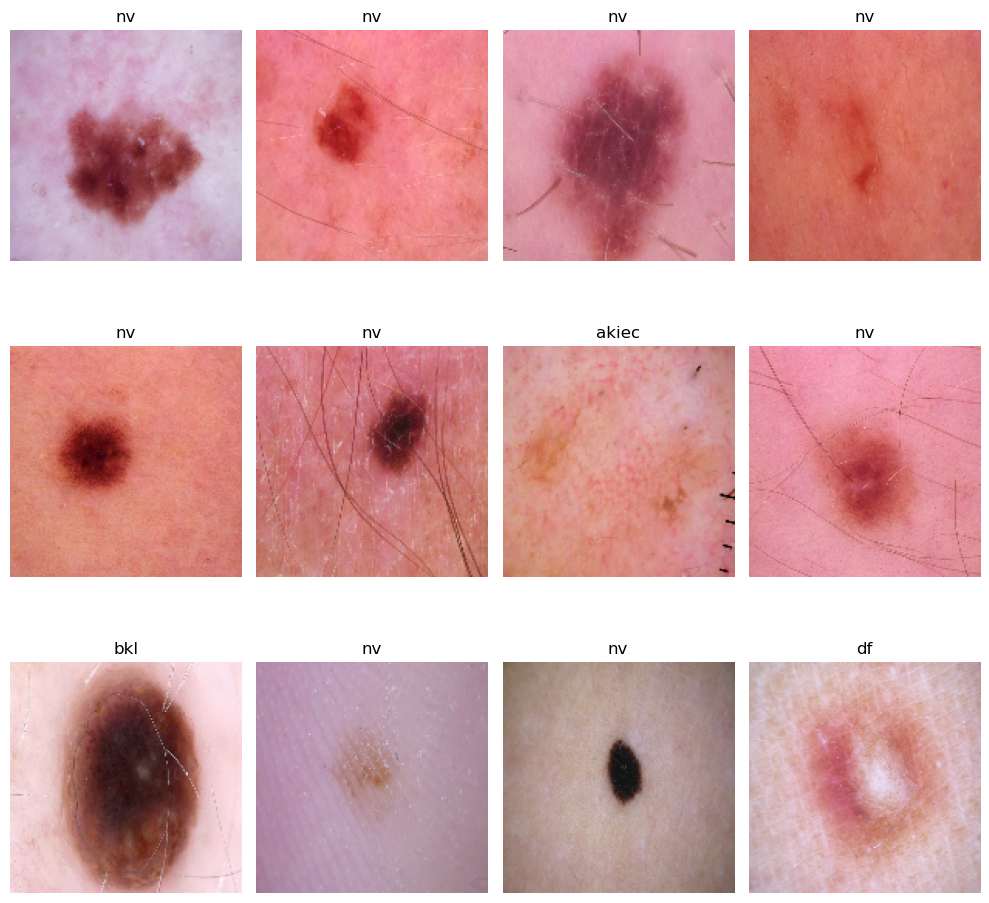

In [5]:
import shutil
import random
import numpy as np
# Import the necessary library for visualization
import matplotlib.pyplot as plt


# Function to display images in a grid
def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(3, 4, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax, label in zip(images_arr, axes, labels_arr):
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Get class labels from the generator
class_labels = {v: k for k, v in train_generator.class_indices.items()}

# Convert one-hot encoded labels to class names
labels = [class_labels[np.argmax(label)] for label in labels]

# Visualize the images and labels
plot_images(images[:12], labels[:12])

In [6]:
#Function to Split Dataset
len(metadata)

10015

In [10]:
train_size = 0.8
len(metadata)*train_size

8012.0

In [11]:
train_ds = metadata[:8012]

len(train_ds)

8012

In [12]:
test_ds = metadata.iloc[8012:]

len(test_ds)

2003

In [13]:
val_size=0.1
len(metadata)*val_size

1001.5

In [14]:
val_ds = test_ds.iloc[:1001]

len(val_ds)

1001

In [15]:
test_ds = test_ds.iloc[1001:]

len(test_ds)

1002

In [16]:
import numpy as np
import pandas as pd

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True):
    assert train_split + val_split + test_split == 1, "Splits must add up to 1"
    
    if shuffle:
        df = df.sample(frac=1, random_state=12).reset_index(drop=True)
    
    train_size = int(train_split * len(df))
    val_size = int(val_split * len(df))
    
    train_ds = df[:train_size]
    val_ds = df[train_size:train_size + val_size]
    test_ds = df[train_size + val_size:]
    
    return train_ds, val_ds, test_ds

# Assuming 'metadata' is your DataFrame
train_ds, val_ds, test_ds = get_dataset_partitions_pd(metadata)


In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_pd(metadata)
print(len(train_ds), len(val_ds), len(test_ds))


8012 1001 1002


In [61]:
import tensorflow as tf

# Convert Pandas DataFrame to TensorFlow Dataset
def df_to_tf_dataset(df):
    df = df.copy()
    labels = df.pop('dx_class')  # Assuming your label column is named 'label'
    return tf.data.Dataset.from_tensor_slices((dict(df), labels))

# Convert train_ds, val_ds, and test_ds to TensorFlow datasets
train_tf_ds = df_to_tf_dataset(train_ds)
val_tf_ds = df_to_tf_dataset(val_ds)
test_tf_ds = df_to_tf_dataset(test_ds)

# Cache, Shuffle, and Prefetch the Dataset
train_tf_ds = train_tf_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_tf_ds = val_tf_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_tf_ds = test_tf_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [62]:
import os
import shutil
import random
import pandas as pd
import tensorflow as tf

def organize_dataset(metadata_path, image_folders, target_base_dir, train_ratio=0.8, val_ratio=0.1):
    metadata = pd.read_csv(metadata_path)
    categories = metadata['dx_class'].unique()
    
    for category in categories:
        os.makedirs(os.path.join(target_base_dir, 'train', category), exist_ok=True)
        os.makedirs(os.path.join(target_base_dir, 'val', category), exist_ok=True)
        os.makedirs(os.path.join(target_base_dir, 'test', category), exist_ok=True)
    
    for index, row in metadata.iterrows():
        img_file = row['image_id'] + '.jpg'
        label = row['dx_class']
        
        # Search for the image file in the provided image folders
        src_file = None
        for folder in image_folders:
            potential_path = os.path.join(folder, img_file)
            if os.path.exists(potential_path):
                src_file = potential_path
                break
        
        if not src_file:
            continue
        
        split = random.random()
        if split < train_ratio:
            dst_dir = 'train'
        elif split < train_ratio + val_ratio:
            dst_dir = 'val'
        else:
            dst_dir = 'test'
        
        dst_file = os.path.join(target_base_dir, dst_dir, label, img_file)
        os.makedirs(os.path.dirname(dst_file), exist_ok=True)
        shutil.copy(src_file, dst_file)

# Function to split dataset into train, val, and test sets
def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True):
    assert train_split + val_split + test_split == 1, "Splits must add up to 1"
    
    if shuffle:
        df = df.sample(frac=1, random_state=12).reset_index(drop=True)
    
    train_size = int(train_split * len(df))
    val_size = int(val_split * len(df))
    
    train_ds = df[:train_size]
    val_ds = df[train_size:train_size + val_size]
    test_ds = df[train_size + val_size:]
    
    return train_ds, val_ds, test_ds

# Convert Pandas DataFrame to TensorFlow Dataset
def df_to_tf_dataset(df):
    df = df.copy()
    labels = df.pop('dx_class')  # Assuming your label column is named 'dx'
    return tf.data.Dataset.from_tensor_slices((dict(df), labels))

# Define source directories and target base directory
metadata_path = 'HAM10000_metadata.csv'  # Change this path accordingly
image_folders = ['HAM10000_images_part_1', 'HAM10000_images_part_2']  # Change these paths accordingly
target_base_dir = 'dataset'

# Organize the dataset
organize_dataset(metadata_path, image_folders, target_base_dir)

# Load metadata into a DataFrame
metadata = pd.read_csv(metadata_path)

# Split dataset into train, val, and test sets
train_ds, val_ds, test_ds = get_dataset_partitions_pd(metadata)

# Convert train_ds, val_ds, and test_ds to TensorFlow datasets
train_tf_ds = df_to_tf_dataset(train_ds)
val_tf_ds = df_to_tf_dataset(val_ds)
test_tf_ds = df_to_tf_dataset(test_ds)

# Cache, Shuffle, and Prefetch the Dataset
train_tf_ds = train_tf_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_tf_ds = val_tf_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_tf_ds = test_tf_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Print lengths of train, val, and test sets
print(len(train_ds), len(val_ds), len(test_ds))


8012 1001 1002


In [22]:
print(test_ds.columns)

Index(['lesion_id', 'image_id', 'dx_class', 'dx_type', 'age', 'sex',
       'localization'],
      dtype='object')


In [74]:
import os
import shutil
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Define paths
metadata_path = 'HAM10000_metadata.csv'
image_folders = ['HAM10000_images_part_1', 'HAM10000_images_part_2']
target_base_dir = 'dataset'

# Function to organize the dataset
def organize_dataset(metadata_path, image_folders, target_base_dir, train_ratio=0.8, val_ratio=0.1):
    metadata = pd.read_csv(metadata_path)
    categories = metadata['dx_class'].unique()
    
    for category in categories:
        os.makedirs(os.path.join(target_base_dir, 'train', category), exist_ok=True)
        os.makedirs(os.path.join(target_base_dir, 'val', category), exist_ok=True)
        os.makedirs(os.path.join(target_base_dir, 'test', category), exist_ok=True)
    
    for index, row in metadata.iterrows():
        img_file = row['image_id'] + '.jpg'
        label = row['dx_class']
        
        # Search for the image file in the provided image folders
        src_file = None
        for folder in image_folders:
            potential_path = os.path.join(folder, img_file)
            if os.path.exists(potential_path):
                src_file = potential_path
                break
        
        if not src_file:
            continue
        
        split = random.random()
        if split < train_ratio:
            dst_dir = 'train'
        elif split < train_ratio + val_ratio:
            dst_dir = 'val'
        else:
            dst_dir = 'test'
        
        dst_file = os.path.join(target_base_dir, dst_dir, label, img_file)
        shutil.copy(src_file, dst_file)

# Organize the dataset
organize_dataset(metadata_path, image_folders, target_base_dir)

# ImageDataGenerator for loading and preprocessing images
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_tf_ds = train_datagen.flow_from_directory(
    os.path.join(target_base_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

val_tf_ds = val_datagen.flow_from_directory(
    os.path.join(target_base_dir, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

test_tf_ds = test_datagen.flow_from_directory(
    os.path.join(target_base_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)



Found 10015 images belonging to 7 classes.
Found 9869 images belonging to 7 classes.
Found 9875 images belonging to 7 classes.


In [75]:
# Define model architecture
input_shape = (224, 224, 3)
n_classes = len(train_tf_ds.class_indices)

model = models.Sequential([
    layers.Input(shape=input_shape),  # Define input layer with input_shape
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Display model summary to verify the architecture and parameters
model.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_56 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_57 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_58 (MaxPooling2D)      │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_59 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_60 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_61 (MaxPooling2D)      │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,719 (670.78 KB)

 Trainable params: 171,719 (670.78 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_tf_ds,
    validation_data=val_tf_ds,
    epochs=100,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_tf_ds)
print(f'Test Accuracy: {test_acc}')


Epoch 1/100


C:\Users\User\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - accuracy: 0.6600 - loss: 1.1115 - val_accuracy: 0.6698 - val_loss: 0.9588
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.6606 - loss: 0.9866 - val_accuracy: 0.6710 - val_loss: 0.9509
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.6747 - loss: 0.9226 - val_accuracy: 0.6976 - val_loss: 0.8484
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.6968 - loss: 0.8666 - val_accuracy: 0.7125 - val_loss: 0.8440
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.7005 - loss: 0.8459 - val_accuracy: 0.7210 - val_loss: 0.8002
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.7096 - loss: 0.8066 - val_accuracy: 0.7213 - val_loss: 0.7722
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.7128 - loss: 0.7875 - val_accuracy: 0.7371 - val_loss: 0.7281
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - accuracy: 0.7313 - loss: 0.7306 - val_accuracy

313/313 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.9626 - loss: 0.1189 - val_accuracy: 0.9605 - val_loss: 0.1083
Epoch 51/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.9718 - loss: 0.0856 - val_accuracy: 0.9911 - val_loss: 0.0246
Epoch 52/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.9767 - loss: 0.0697 - val_accuracy: 0.9956 - val_loss: 0.0156
Epoch 53/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.9942 - loss: 0.0166 - val_accuracy: 0.9921 - val_loss: 0.0251
Epoch 54/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.9865 - loss: 0.0402 - val_accuracy: 0.9722 - val_loss: 0.0781
Epoch 55/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.9629 - loss: 0.1144 - val_accuracy: 0.9671 - val_loss: 0.0958
Epoch 56/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.9800 - loss: 0.0568 - val_accuracy: 0.9875 - val_loss: 0.0346
Epoch 57/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.9907 - loss: 0.0271 - val_a

313/313 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.9893 - loss: 0.0290 - val_accuracy: 0.9931 - val_loss: 0.0185
Epoch 100/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.9866 - loss: 0.0389 - val_accuracy: 0.9811 - val_loss: 0.0520
309/309 ━━━━━━━━━━━━━━━━━━━━ 236s 765ms/step - accuracy: 0.9811 - loss: 0.0542
Test Accuracy: 0.9810633063316345


In [77]:
from tensorflow.keras.models import Sequential, load_model

# Save the model
model.save('my_CNN_model.keras')


In [78]:
#Saving the Model
model.save("my_CNN_model.h5")

In [79]:
#Saving the Model
model.save("my_CNN_model.pb")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=my_CNN_model.pb.

In [80]:
# Load the saved model (if needed)
loaded_model = load_model('my_CNN_model.keras')

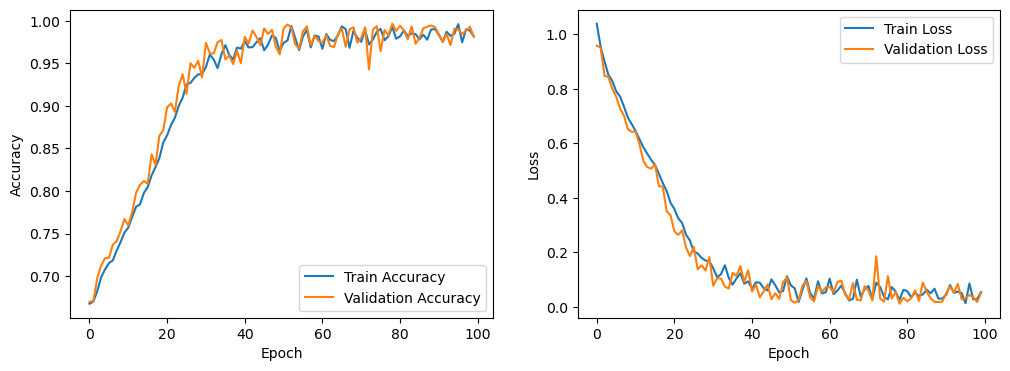

In [81]:
# Plotting the training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
#Run prediction on a sample image
import numpy as np
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # rescale the image
    return img_array

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


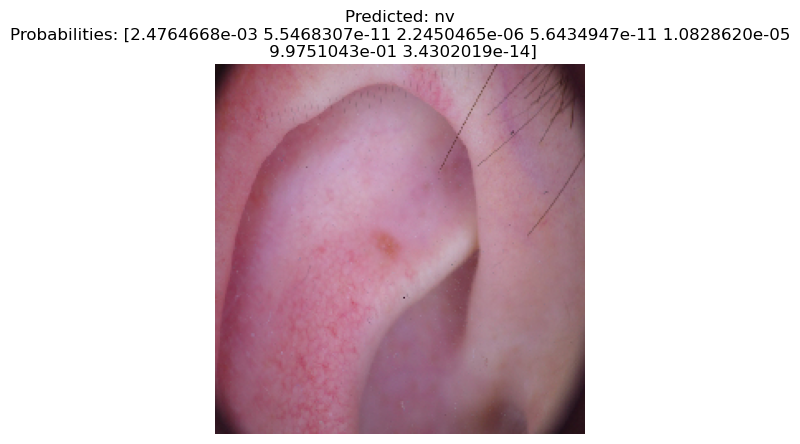

In [83]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img, img_array

def predict_image(model, img_path, class_indices):
    # Load and preprocess the image
    img, img_array = load_and_preprocess_image(img_path)
    
    # Make a prediction
    predictions = model.predict(img_array)
    
    # Decode the prediction
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    
    # Map the index to the class label
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class_label = class_labels[predicted_class_index]
    
    return img, predicted_class_label, predictions[0]

def display_prediction(img, predicted_label, prediction_probabilities):
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}\nProbabilities: {prediction_probabilities}")
    plt.axis('off')
    plt.show()

# Example usage
img_path = 'ISIC_0029389.jpg'  # Replace with the path to your image
img, predicted_label, prediction_probabilities = predict_image(model, img_path, train_generator.class_indices)
display_prediction(img, predicted_label, prediction_probabilities)


In [84]:
from tensorflow.keras.models import Sequential, load_model

# Save the model
model.save('my_CNN_model.keras')
